# Generic Example Test for Differential Evolution Based Symbolic Regression (DESR) for Equation: y = sin(X) + 2 + e #

## Import Relevant Packages ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys;sys.path.append("../")
from desr import Generator, Equation, TrainingData, \
                 Optimizer, LaplaceApproximation, DifferentialEvolution

## Initialize Data (This can be done using either numpy/torch for data) ##

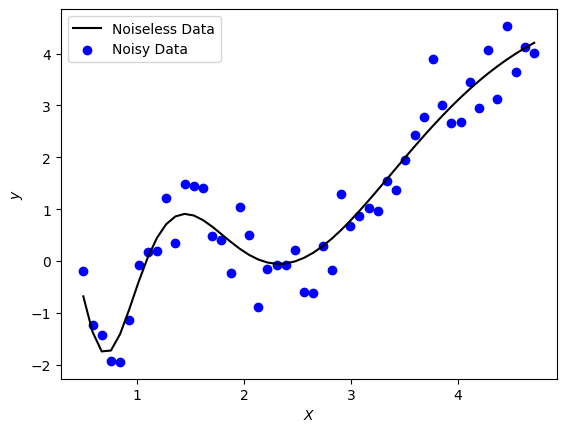

In [2]:
std_dev = 0.4
X = np.linspace(0.5, 3*np.pi/2, 50)
y = np.sin(np.log(X)*5) + X - 1.5 
y_noisy = y + np.random.normal(loc=0, scale=std_dev, size=X.shape)
training_data = TrainingData(x=X, y=y_noisy)

plt.plot(X, y, label="Noiseless Data", color="k")
plt.scatter(X, y_noisy, label="Noisy Data", color="b")
plt.xlabel(r"$X$")
plt.ylabel(r"$y$")
plt.legend()


## Initialize Optimizer (Used for deterministic optimization), Generator and Operators ##

In [3]:

optimizer = Optimizer(training_data)
generator = Generator(genotype_size=16, X_dim=training_data.x.shape[1])
operators = ["add", "sub", "mult", "log", "sin", "pow"]
generator.add_operators(operators)


## Initialize Bayesian Fitness (Laplace Approximation for Marginal Likelihood) and Differential Evolution Instance

In [4]:
laplace_approximation = LaplaceApproximation(optimizer)
differential_evolution = DifferentialEvolution(chains=20, generator=generator,
                            bayesian_fitness=laplace_approximation)

equation = Equation(expression="sin(log(X_0)) + X_0 - 1.5")
print(f"Target Fitness: {laplace_approximation(equation)}")

Target Fitness: 70.6505468698365


/Users/nolanstrauss/codes/DESR/examples/../desr/bayesian_fitness/laplace_approximation.py:38: RuntimeWarning: divide by zero encountered in log
  np.log(norm(loc=0, scale=std).pdf(R.detach().numpy()))


## Generate Samples Using Differential Evolution ##

In [5]:
differential_evolution.sample(iterations=100, return_states=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:27,  3.59it/s]/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
  5%|▌         | 5/100 [00:01<00:23,  4.10it/s]/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:292: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


## Print All Unique Accepted States and Fitness (From high to low, note: fitness=inf may occur due to nan comparisons in initial stages) ##

In [8]:
N = 5 #This restricts the print to the N best fit equations found
for i, state in enumerate(differential_evolution.unique_accepted_states[-N:]):
    print(f"Model_{i} Expression: {str(state)}")
    print(f"Model_{i} Fitness: {str(state.fitness)}\n")

Model_0 Expression: ((C_0 + (-1 * sin(X_0))) + (((C_1 * -1) + sin(X_0)) * sin(X_0)))
Model_0 Fitness: 67.84650658615453

Model_1 Expression: (C_0 + (((C_1 * -1) + sin(X_0)) * sin(X_0)))
Model_1 Fitness: 67.84426397306315

Model_2 Expression: (((-1 * sin(X_0)) + (((C_1 * -1) + sin(X_0)) * sin(X_0))) + sin(C_0))
Model_2 Fitness: 67.84426370612981

Model_3 Expression: (C_1 + (((C_0 * -1) + sin(X_0)) * sin(X_0)))
Model_3 Fitness: 67.84426364115208

Model_4 Expression: ((C_0 + C_2) + (((C_1 * -1) + sin(X_0)) * sin(X_0)))
Model_4 Fitness: 67.84426352932361



## Print Unique Final Accepted States and Fitness (From high to low) ##

In [9]:
for i, state in enumerate(differential_evolution.unique_states):
    print(f"Model_{i} Expression: {str(state)}")
    print(f"Model_{i} Fitness: {str(state.fitness)}\n")

Model_0 Expression: (1.372 + (sin(X_0) * -1.867))
Model_0 Fitness: 69.99415878640593

Model_1 Expression: (1.372 + (sin(X_0) * (-2.068 * 0.903)))
Model_1 Fitness: 69.99415841906807

Model_2 Expression: (0.967 + (sin(X_0) * (sin(X_0) - 2.048)))
Model_2 Fitness: 67.8442637601829



## Plot N Unique Accepted States ##

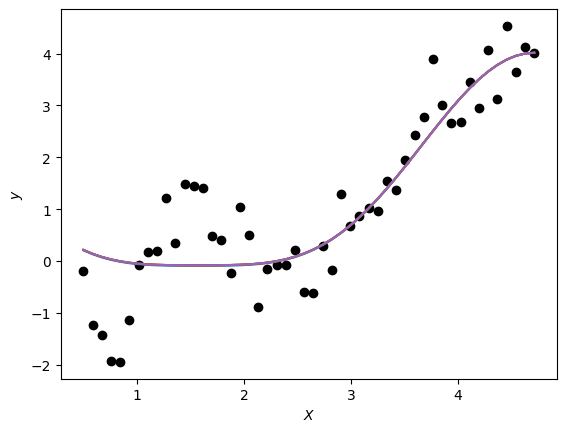

In [11]:
fig, axs = plt.subplots()
axs.scatter(training_data.x.detach().numpy(), training_data.y.detach().numpy(), label="Noisy Data", color="k")

for i, state in enumerate(differential_evolution.unique_accepted_states[-N:]):
    axs.plot(training_data.x.detach().numpy().squeeze(), state.evaluate_equation(training_data.x).detach().numpy().squeeze(), label=f"Model_{i}")
axs.set_xlabel(r"$X$")
axs.set_ylabel(r"$y$")
if N < 5: #Ignore if legend size will be too large.
    axs.legend()